In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np

def crop_root(image_path, output_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError("Image not found")

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_blue = np.array([60, 60, 0])
    upper_blue = np.array([210, 255, 255])

    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    closing_kernel = np.ones((10,10), np.uint8)
    opening_kernel = np.ones((45,45), np.uint8)

    closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, closing_kernel, iterations=2)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, opening_kernel, iterations=1)


    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    largest_contour = max(contours, key=cv2.contourArea)

    x, y, w, h = cv2.boundingRect(largest_contour)

    cropped_image = image[y:y+h, x:x+w]

    cv2.imwrite('result.png', cropped_image)

    cv2.imwrite('mask.jpg', mask)
    cv2.imwrite('opening.jpg', opening)

image_path = "/content/IMG_2904.JPG"
output_path = "/content/Cropped.PNG"
crop_root(image_path, output_path)

In [ ]:
import cv2
import numpy as np
import os
from pathlib import Path
import shutil
def crop_root(image_path, output_path):
    # Read image
    image = cv2.imread(str(image_path))
    if image is None:
        print(f"Image not found: {image_path}")
        return

    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define blue range for masking
    lower_blue = np.array([60, 60, 0])
    upper_blue = np.array([210, 255, 255])

    # Create mask
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Morphological operations
    closing_kernel = np.ones((10,10), np.uint8)
    opening_kernel = np.ones((45,45), np.uint8)
    closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, closing_kernel, iterations=2)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, opening_kernel, iterations=1)

    # Find contours
    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print(f"No contours found in image: {image_path}")
        return

    # Get bounding rectangle of largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image
    cropped_image = image[y:y+h, x:x+w]

    # Update output path to .png
    output_path = output_path.with_suffix('.png')
    output_path.parent.mkdir(parents=True, exist_ok=True)

    # Save cropped image as PNG
    cv2.imwrite(str(output_path), cropped_image)

def process_all_folders(input_base_path, output_base_path):
    folders = ['LR-70'] #'LR-26', 'LR-68', 'LR-70', 'LR-86'

    for folder in folders:
        input_folder = Path(input_base_path) / folder
        output_folder = Path(output_base_path) / folder

        if not input_folder.exists():
            print(f"Input folder not found: {input_folder}")
            continue
        count=0
        # Process each image file
        for image_file in sorted(input_folder.glob('*.JPG')):
            count+=1
            output_file = output_folder / image_file.name
            crop_root(image_file, output_file)
            print(f"Processed: {image_file} -> {output_file.with_suffix('.png')}")
        print(f"total_count={count}")

# Base paths
input_base_path = "/content/drive/MyDrive/CMPT898_Project/898_Files/Dataset"
output_base_path = "/content/drive/MyDrive/CMPT898_Project/898_Files/Cropped Dataset"

# Run processing
process_all_folders(input_base_path, output_base_path)

Processed: /content/drive/MyDrive/CMPT898_Project/898_Files/Dataset/LR-70/IMG_3358.JPG -> /content/drive/MyDrive/CMPT898_Project/898_Files/Cropped Dataset/LR-70/IMG_3358.png
Processed: /content/drive/MyDrive/CMPT898_Project/898_Files/Dataset/LR-70/IMG_3359.JPG -> /content/drive/MyDrive/CMPT898_Project/898_Files/Cropped Dataset/LR-70/IMG_3359.png
Processed: /content/drive/MyDrive/CMPT898_Project/898_Files/Dataset/LR-70/IMG_3360.JPG -> /content/drive/MyDrive/CMPT898_Project/898_Files/Cropped Dataset/LR-70/IMG_3360.png
Processed: /content/drive/MyDrive/CMPT898_Project/898_Files/Dataset/LR-70/IMG_3361.JPG -> /content/drive/MyDrive/CMPT898_Project/898_Files/Cropped Dataset/LR-70/IMG_3361.png
Processed: /content/drive/MyDrive/CMPT898_Project/898_Files/Dataset/LR-70/IMG_3362.JPG -> /content/drive/MyDrive/CMPT898_Project/898_Files/Cropped Dataset/LR-70/IMG_3362.png
Processed: /content/drive/MyDrive/CMPT898_Project/898_Files/Dataset/LR-70/IMG_3363.JPG -> /content/drive/MyDrive/CMPT898_Project/8

In [ ]:
import os

def count_images(folder, extension=".JPG"):
    return len([file for file in os.listdir(folder) if file.endswith(extension)])

folder = "/content/drive/MyDrive/CMPT898_Project/898_Files/Dataset/LR-70"
image_count = count_images(folder)
print(f"Total number of images: {image_count}")


Total number of images: 455


In [1]:
import cv2
import numpy as np
import os
from pathlib import Path
import shutil
from skimage import morphology, measure, util
import matplotlib.pyplot as plt

def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype('uint8')
    return cv2.LUT(image, table)

def extract_root_region(cropped_image):
    # Convert to grayscale
    image_gray = util.img_as_float(cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY))
    # Equalize histogram to enhance contrast
    image_gray = cv2.equalizeHist((image_gray * 255).astype('uint8'))

    # Apply gamma correction to make the root more visible
    image_gray= adjust_gamma(image_gray, gamma=0.01)

    plt.imshow(image_gray, cmap='gray')

    # Apply morphological operations to extract root
    struct_element = morphology.disk(2)
    mask = morphology.binary_opening(image_gray, struct_element)
    mask = morphology.binary_closing(mask, struct_element)

    # Label regions in the mask
    labeled = measure.label(mask)
    regions = measure.regionprops(labeled)

    if len(regions) == 0:
        print("No regions found for root extraction.")
        return None

    # Find the largest region, which is likely the root
    largest_region = max(regions, key=lambda r: r.area)
    mask = labeled == largest_region.label

    print(f"Number of regions found: {len(regions)}")

    plt.figure()
    plt.imshow(mask, cmap='gray')
    plt.title('Largest Connected Component ')
    plt.show()
    return mask

def apply_mask_to_image(image, mask):
    # Ensure mask is binary
    mask = (mask > 0).astype(np.uint8)

    # Apply the mask to the original image
    result = cv2.bitwise_and(image, image, mask=mask)

    return result


def process_all_folders(input_base_path, output_base_path):
    folders = ['LR-70'] # Add other folders as needed

    for folder in folders:
        input_folder = Path(input_base_path) / folder
        output_folder = Path(output_base_path) / folder
        count=0
        # Process each image file
        for image_file in sorted(input_folder.glob('*.png')):
            count+=1
            output_file = output_folder / image_file.name
            cropped_image = cv2.imread(str(image_file))
            root_mask = extract_root_region(cropped_image)
            apply_mask_to_root_only_image = apply_mask_to_image(cropped_image, root_mask)
            plt.figure()
            plt.imshow(apply_mask_to_root_only_image)
            plt.title('Final Image')
            plt.show()

            # output_file = output_file.with_suffix('.png')
            # output_file.parent.mkdir(parents=True, exist_ok=True)

            # cv2.imwrite(str(output_file), root_only_image)
            print(f"Cropped and processed root saved at: {output_file}")


        print(f"Total processed images in {folder}: {count}")

# Base paths
input_base_path = "/content/drive/MyDrive/CMPT898_Project/898_Files/Cropped Dataset"
output_base_path = "/content/drive/MyDrive/CMPT898_Project/898_Files/New_Cropped_Dataset"

# Run processing
process_all_folders(input_base_path, output_base_path)

Total processed images in LR-70: 0


Number of regions found: 5065


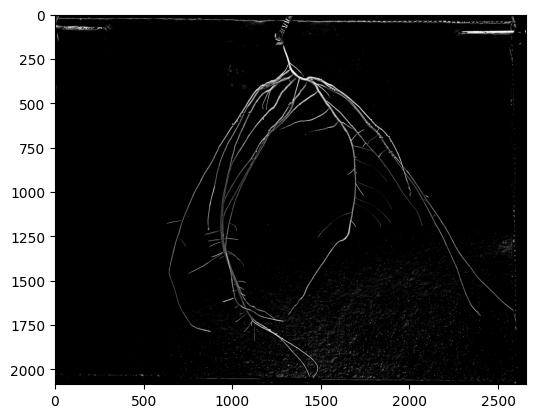

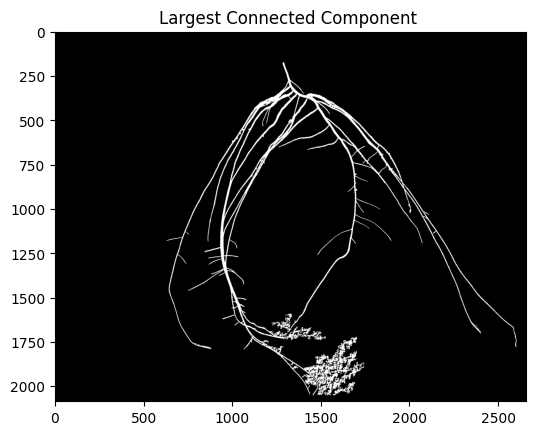

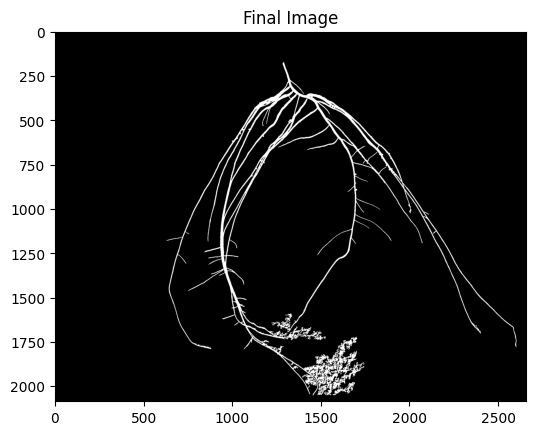

In [7]:
import cv2
import numpy as np
import os
from pathlib import Path
import shutil
from skimage import morphology, measure, util
import matplotlib.pyplot as plt

def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype('uint8')
    return cv2.LUT(image, table)

def extract_root_region(cropped_image):
    # Convert to grayscale
    image_gray = util.img_as_float(cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY))
    # Equalize histogram to enhance contrast
    image_gray = cv2.equalizeHist((image_gray * 255).astype('uint8'))

    # Apply gamma correction to make the root more visible
    image_gray= adjust_gamma(image_gray, gamma=0.02)

    plt.imshow(image_gray, cmap='gray')

    # Apply morphological operations to extract root
    struct_element = morphology.disk(1)
    mask = morphology.binary_opening(image_gray, struct_element)
    mask = morphology.binary_closing(mask, struct_element)

    # Label regions in the mask
    labeled = measure.label(mask)
    regions = measure.regionprops(labeled)

    if len(regions) == 0:
        print("No regions found for root extraction.")
        return None

    # Find the largest region, which is likely the root
    largest_region = max(regions, key=lambda r: r.area)
    mask = labeled == largest_region.label

    print(f"Number of regions found: {len(regions)}")

    plt.figure()
    plt.imshow(mask, cmap='gray')
    plt.title('Largest Connected Component ')
    plt.show()
    return mask

def apply_mask_to_image(image, mask):
    mask = (mask > 0).astype(np.uint8)
    result = cv2.bitwise_and(image, image, mask=mask)

    return result

cropped_image = cv2.imread("/content/IMG_3381.png")
root_mask = extract_root_region(cropped_image)
apply_mask_to_root_only_image = apply_mask_to_image(cropped_image, root_mask)
plt.figure()
plt.imshow(root_mask, cmap='gray')
plt.title('Final Image')
plt.show()